# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import time 
import numpy as np
import pandas as pd
from pathlib import Path
import calendar
from collections import Counter
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from imblearn import over_sampling as os
from imblearn import pipeline as pl
from imblearn.metrics import (geometric_mean_score, make_index_balanced_accuracy)
from imblearn.ensemble import EasyEnsembleClassifier
import pydotplus
from IPython.display import Image
from matplotlib import pyplot as plt

## Read the CSV and Perform Basic Data Cleaning

In [2]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [3]:
# Create our features
X = pd.get_dummies(df.drop('loan_status', axis = 1))

# Create our target
y = df['loan_status']

In [4]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [5]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [6]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test= train_test_split(X, 
                                                   y, 
                                                   random_state=1, 
                                                   stratify=y)
X_train.shape

(51612, 95)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [7]:
# Create the StandardScaler instance
scaler = StandardScaler(copy=True, with_mean=False, with_std=False)

In [8]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [9]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [10]:
# Choose learning rate
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=learning_rate,
        max_features=2,
        max_depth=3,
        random_state=0)
    model.fit(X_train_scaled,y_train.ravel())
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        model.score(
            X_train_scaled,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        model.score(
            X_test_scaled,
            y_test.ravel())))
    print()

Learning rate:  0.05
Accuracy score (training): 0.996
Accuracy score (validation): 0.996

Learning rate:  0.1
Accuracy score (training): 0.997
Accuracy score (validation): 0.996

Learning rate:  0.25
Accuracy score (training): 0.995
Accuracy score (validation): 0.994

Learning rate:  0.5
Accuracy score (training): 0.991
Accuracy score (validation): 0.990

Learning rate:  0.75
Accuracy score (training): 0.387
Accuracy score (validation): 0.385

Learning rate:  1
Accuracy score (training): 0.030
Accuracy score (validation): 0.032



In [11]:
# Build model with optimal learning rateby using GradientTreeClassifier to leverage ensemble learning
model = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=1,
    max_features=5,
    max_depth=3,
    random_state=0)

# Fit the model
model.fit(X_train_scaled, y_train.ravel())

# Score the model
print("Accuracy score (training): {0:.3f}".format(
    model.score(
        X_train_scaled,
        y_train)))
print("Accuracy score (validation): {0:.3f}".format(
    model.score(
        X_test_scaled,
        y_test)))

Accuracy score (training): 0.509
Accuracy score (validation): 0.513


In [12]:
 # Make predictions
predictions = model.predict(X_test_scaled)

# Generate accuracy score for predictions using y_test
accuracy_score(y_test, predictions)

0.5128741644870677

In [13]:
# Generatring the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=[
        "Predicted 0",
        "Predicted 1"
    ]
)

display(cm_df)

,Predicted 0,Predicted 1
Actual 0,43,44
Actual 1,8337,8781


In [14]:
# Geometric mean score
y_pred_model = model.predict(X_test)
print('The geometric mean is {}'.format(geometric_mean_score(
    y_test,
    predictions)))

The geometric mean is 0.5035238880175754


## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [15]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=1)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(n_estimators=1000, random_state=1)

In [16]:
# Calculated the balanced accuracy score
y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.8192848020434227

In [17]:
# Display the confusion matrix
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["High Risk", "Low Risk"],
    columns=["Positive", "Negative"]
)

,Positive,Negative
High Risk,62,25
Low Risk,1268,15850


In [18]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.05      0.71      0.93      0.09      0.81      0.65        87
   low_risk       1.00      0.93      0.71      0.96      0.81      0.67     17118

avg / total       0.99      0.92      0.71      0.96      0.81      0.67     17205



In [19]:
# List the features sorted in descending order by feature importance
start_time = time.time()
importances = brf.feature_importances_
std = np.std([tree.feature_importances_ for tree in brf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# Generate list of important features 
importances_sorted = sorted(zip(brf.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]


Elapsed time to compute the importances: 0.336 seconds


[(0.06928717515721282, 'total_rec_prncp'),
 (0.06195341602973416, 'total_rec_int'),
 (0.05999716770508804, 'total_pymnt'),
 (0.05944929931774028, 'total_pymnt_inv'),
 (0.05780080255994967, 'last_pymnt_amnt'),
 (0.02708701665429169, 'int_rate'),
 (0.019362938516910073, 'issue_d_Jan-2019'),
 (0.01765723264865733, 'dti'),
 (0.01635551128868266, 'installment'),
 (0.0162869588930354, 'out_prncp')]

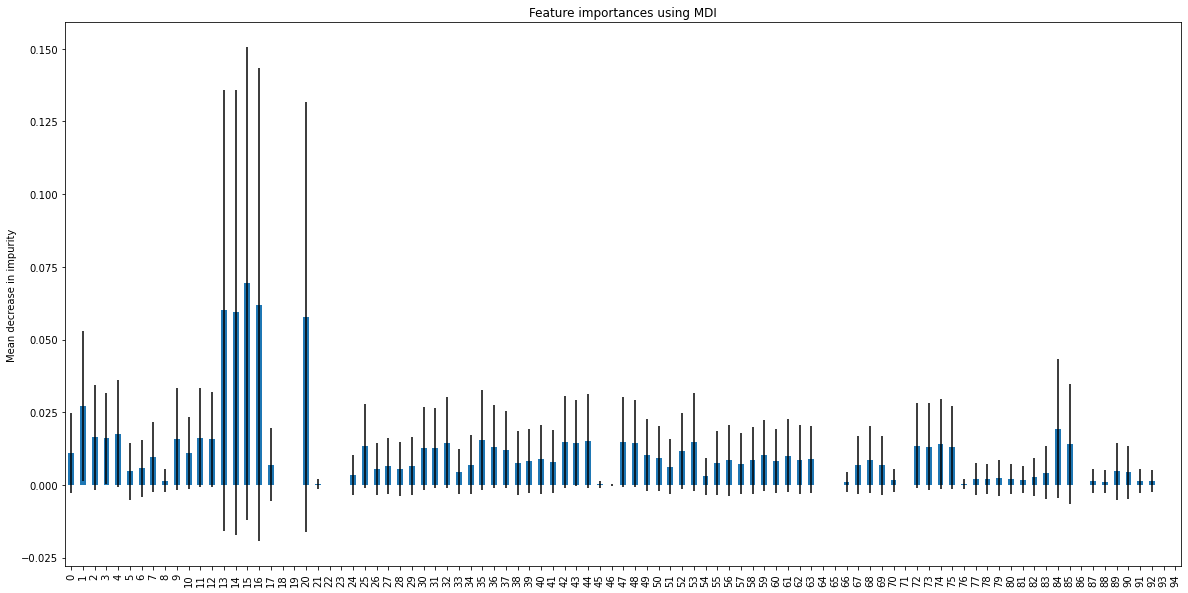

In [20]:
# Plot impurity based importance
importances_sorted = pd.Series(importances)
fig, ax = plt.subplots(figsize=(20,10))
importances_sorted.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.show()

In [21]:
# Feature importance based on mean decrease in impurity
start_time = time.time()
importances = brf.feature_importances_
std = np.std([tree.feature_importances_ for tree in brf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


Elapsed time to compute the importances: 0.338 seconds


In [22]:
# Feature importance based on feature permutation 
start_time = time.time()
result = permutation_importance(brf, 
                                X_test, 
                                y_test, 
                                n_repeats=10, 
                                random_state=42, 
                                n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

importances = pd.Series(result.importances_mean, importances)

Elapsed time to compute the importances: 2989.906 seconds


In [23]:
# Generate list of important features 
importances_sorted = sorted(zip(brf.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.06928717515721282, 'total_rec_prncp'),
 (0.06195341602973416, 'total_rec_int'),
 (0.05999716770508804, 'total_pymnt'),
 (0.05944929931774028, 'total_pymnt_inv'),
 (0.05780080255994967, 'last_pymnt_amnt'),
 (0.02708701665429169, 'int_rate'),
 (0.019362938516910073, 'issue_d_Jan-2019'),
 (0.01765723264865733, 'dti'),
 (0.01635551128868266, 'installment'),
 (0.0162869588930354, 'out_prncp')]

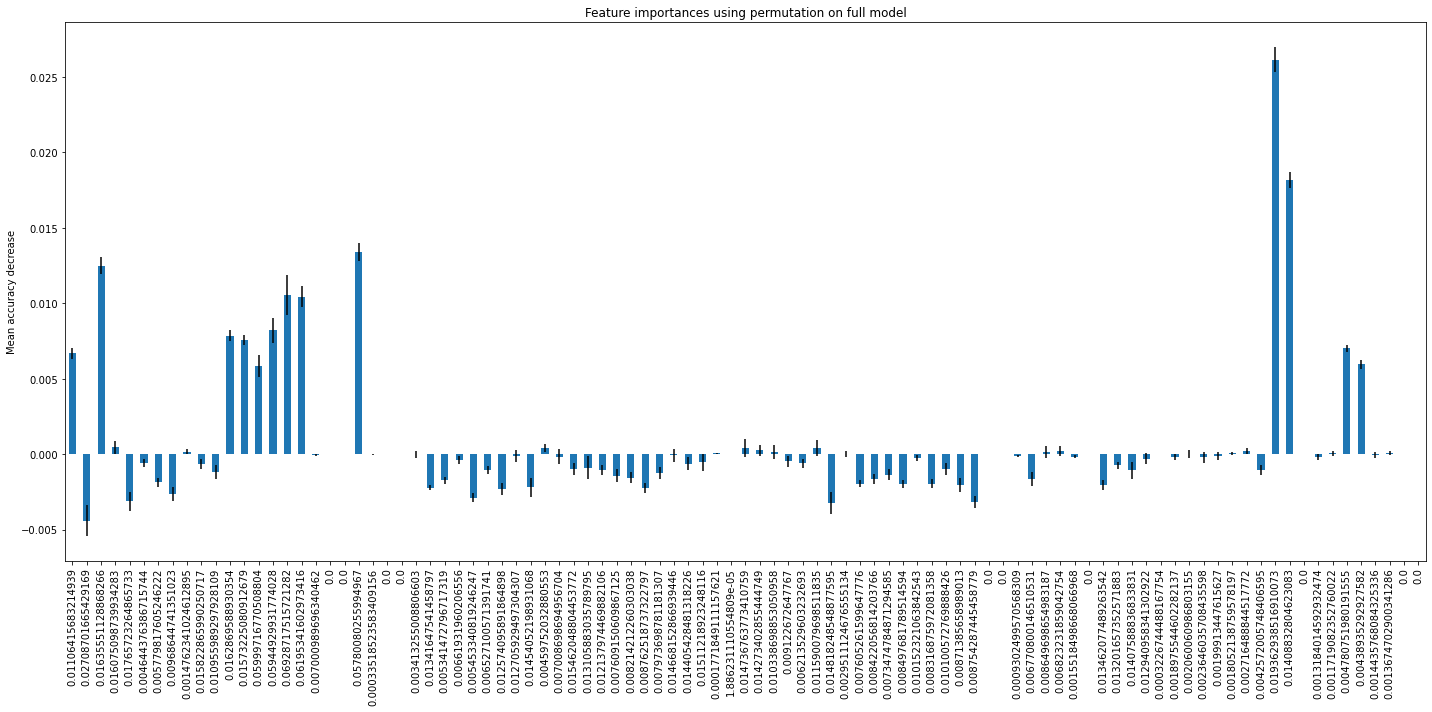

In [24]:
# Plot feature performance based on feature permutation
fig, ax = plt.subplots(figsize=(20,10))
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [25]:
# Geometric mean score
y_pred_brf = brf.predict(X_test)
print('The geometric mean is {}'.format(geometric_mean_score(
    y_test,
    y_pred_brf)))

The geometric mean is 0.8123147527629958


### Easy Ensemble Classifier

In [26]:
# Train the EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec = eec.fit(X_train, y_train)
eec

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [27]:
# Calculated the balanced accuracy score
y_pred_eec = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred_eec)

0.925427358175101

In [28]:
# Display the confusion matrix
pd.DataFrame(
    confusion_matrix(y_test, y_pred_eec),
    index=["High Risk", "Low Risk"],
    columns=["Positive", "Negative"]
)

,Positive,Negative
High Risk,79,8
Low Risk,979,16139


In [29]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_eec))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.07      0.91      0.94      0.14      0.93      0.85        87
   low_risk       1.00      0.94      0.91      0.97      0.93      0.86     17118

avg / total       0.99      0.94      0.91      0.97      0.93      0.86     17205



In [30]:
# Geometric mean score
y_pred_eec = eec.predict(X_test)
print('The geometric mean is {}'.format(geometric_mean_score(
    y_test,
    y_pred_eec)))

The geometric mean is 0.9252641151843035


### Final Questions

**Which model had the best balanced accuracy score?**

The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets is defined as the average of recall obtained on each class. 

The best value is 1 and the worst value is 0 when 'ajusted=False, which is a default setting. 

*sklearn.metrics.balanced_accuracy_score(y_true, y_pred, *, sample_weight=None, adjusted=False).*

My analysis concludes that the Easy Ensemble model outperformed the others with a score of 0.925427358175101.

**Which model had the best recall score?**

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The best value is 1 and the worst value is 0.

**Which model had the best geometric mean score?**

The geometric mean (G-mean) is the root of the product of class-wise sensitivity. This measure tries to maximize the accuracy on each of the classes while keeping these accuracies balanced. For binary classification G-mean is the squared root of the product of the sensitivity and specificity. For multi-class problems it is a higher root of the product of sensitivity for each class.

The geometric mean scores for all models are below: 
* GradientTreeClassifier: 0.5035238880175754 
* Easy Ensemble Classifier: 0.9252641151843035
* Balanced Random Forest Classifier: 0.8123147527629958

**What are the top three features?**

*Feature importance based on mean decrease in impurity*

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree. 

Impurity-based feature importances can be misleading for high cardinality features. Importance based on feature permutation can be used to overcome this limitation.

Fitting impurity-based features to the model results in the following top three features: 
* total_rec_prncp
* total_rec_int
* total_pymnt

*Feature importance based on feature permutation*

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

Fitting permutation based features to the model results in the following top three features: 
* Feature 1 *(script calculating permuation features for 35+ mins at the time of writing. Notebook will be updated with result when complete)*
* Feature 2 
* Feature 3